In [ ]:
#!pip install librosa 
#!pip install soundfile 
#!pip install numpy
#!pip install sklearn 
#!pip install pyaudio
#!pip install matplotlib

In [ ]:
import os
import pandas as pd
import soundfile as sf 
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# monte o drive para acessar os dados do VERBO 
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
VERBO = '/content/drive/MyDrive/VERBO_OK/'
dir_list = os.listdir(VERBO)
dir_list.pop(3)

'features'

In [ ]:
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(VERBO + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(part[0])
        temp = part[1]
        if temp == "f1" or temp =='f2' or temp == 'f3' or temp == 'f4' or temp == 'f5' or temp == 'f6':
            temp = "feminino"
        else:
            temp = "masculino"
        gender.append(temp)
        path.append(VERBO + i + '/' + f)

        
VERBO_df = pd.DataFrame(emotion)
VERBO_df = VERBO_df.replace({'neu':'neutro', 'des':'desgosto', 'ale':'alegre', 'tri':'triste', 'rai':'raiva', 'med':'medo', 'sur':'surpresa'})
VERBO_df = pd.concat([pd.DataFrame(gender),VERBO_df],axis=1)
VERBO_df.columns = ['gender','emotion']
VERBO_df['labels'] = VERBO_df.gender + '_' + VERBO_df.emotion
VERBO_df['source'] = 'VERBO'  
VERBO_df = pd.concat([VERBO_df,pd.DataFrame(path, columns = ['path'])],axis=1)
#VERBO_df = VERBO_df.drop(['gender', 'emotion'], axis=1)
#VERBO_df.labels.value_counts()
VERBO_df.head(20)

,gender,emotion,labels,source,path
0,feminino,desgosto,feminino_desgosto,VERBO,/content/drive/MyDrive/VERBO_OK/f3/des-f3-l1.wav
1,feminino,medo,feminino_medo,VERBO,/content/drive/MyDrive/VERBO_OK/f3/med-f3-l1.wav
2,feminino,neutro,feminino_neutro,VERBO,/content/drive/MyDrive/VERBO_OK/f3/neu-f3-ns4.wav
3,feminino,alegre,feminino_alegre,VERBO,/content/drive/MyDrive/VERBO_OK/f3/ale-f3-ns2.wav
4,feminino,alegre,feminino_alegre,VERBO,/content/drive/MyDrive/VERBO_OK/f3/ale-f3-ns1.wav
5,feminino,alegre,feminino_alegre,VERBO,/content/drive/MyDrive/VERBO_OK/f3/ale-f3-s2.wav
6,feminino,medo,feminino_medo,VERBO,/content/drive/MyDrive/VERBO_OK/f3/med-f3-s2.wav
7,feminino,medo,feminino_medo,VERBO,/content/drive/MyDrive/VERBO_OK/f3/med-f3-s1.wav
8,feminino,desgosto,feminino_desgosto,VERBO,/content/drive/MyDrive/VERBO_OK/f3/des-f3-s1.wav
9,feminino,neutro,feminino_neutro,VERBO,/content/drive/MyDrive/VERBO_OK/f3/neu-f3-ns3.wav


In [ ]:
def audio_features(file_title, mfcc, chroma, mel, zcr):
    with sf.SoundFile(file_title) as audio_recording:
        audio = audio_recording.read(dtype="float32")
        sample_rate = audio_recording.samplerate        
        if chroma:
            stft=np.abs(librosa.stft(audio))
            result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(audio, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if zcr:
            ZCR = np.mean(librosa.feature.zero_crossing_rate(y=audio).T, axis=0)
            result=np.hstack((result, ZCR))      
        return result


In [ ]:
def loading_audio_data():
    x = []
    y = []
    for file in VERBO_df['path']:        
        emotion = file.split('/')[6].split('-')[0]             
        feature = audio_features(str(file), mfcc=True, chroma=True, mel=False, zcr=True)
        
        x.append(feature)   
        y.append(emotion)


    final_dataset = train_test_split(np.array(x), y, test_size=0.1, random_state=9)
    return  final_dataset

In [ ]:
X_train, X_test, y_train, y_test = loading_audio_data()

In [ ]:
# shape do traino e do test
X_train.shape[0], X_test.shape[0]

(1048, 117)

In [ ]:
#MLP Model
model = MLPClassifier(alpha= 0.01, batch_size = 256, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=400 )

In [ ]:
model.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=400,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("A precisão do reconhecedor é: {:.1f}%".format(accuracy*100))

A precisão do reconhecedor é: 81.2%


              precision    recall  f1-score   support

         ale       0.91      0.83      0.87        12
         des       0.45      0.75      0.56        12
         med       0.94      0.89      0.91        18
         neu       0.86      0.82      0.84        22
         rai       1.00      0.62      0.76        13
         sur       0.79      1.00      0.88        15
         tri       0.90      0.76      0.83        25

    accuracy                           0.81       117
   macro avg       0.84      0.81      0.81       117
weighted avg       0.85      0.81      0.82       117

----accuracy score 81.19658119658119 ----


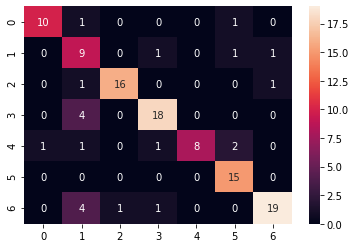

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(y_test,y_pred))

acc = float(accuracy_score(y_test,y_pred))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [ ]:
path_audio_1 = '/content/drive/MyDrive/audio_teste/capitao-bope1-ajuste.wav'
path_audio_2 = '/content/drive/MyDrive/audio_teste/tri-m6-q1.wav'
path_audio_3 = '/content/drive/MyDrive/audio_teste/tri-m6-s1.wav'
path_audio_4 = '/content/drive/MyDrive/audio_teste/caminho_nuvens_ajuste.wav'


audio_1 = audio_features(path_audio_1, mfcc=True, chroma=True, mel=False, zcr=True)
audio_1  = audio_1.reshape(1,-1)
#audio_2 = audio_features(path_audio_2, mfcc=True, chroma=True, mel=True)
#audio_2  = audio_2.reshape(1,-1)
#audio_3 = audio_features(path_audio_3, mfcc=True, chroma=True, mel=True)
#audio_3  = audio_3.reshape(1,-1)
#audio_4 = audio_features(path_audio_4, mfcc=True, chroma=True, mel=True)
#audio_4  = audio_4.reshape(1,-1)

In [ ]:
new_output = model.predict(audio_1)
new_output

ValueError: ignored

In [ ]:
dir_list_coringa = os.listdir('/content/drive/MyDrive/audio_teste/coringa-split/')
for x in range(7):
  path_audio = '/content/drive/MyDrive/audio_teste/coringa-split/'+dir_list_coringa[x]
  audio = audio_features(path_audio, mfcc=True, chroma=True, mel=True)
  audio = audio.reshape(1,-1)
  predictions = model.predict(audio)
  print(predictions)
 

['tri']
['tri']
['tri']
['tri']
['tri']
['tri']
['tri']


In [ ]:
# Arvore de decisao
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("A precisão do reconhecedor é: {:.1f}%".format(accuracy*100))

A precisão do reconhecedor é: 55.6%


In [ ]:

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ale       0.36      0.42      0.38        12
         des       0.50      0.58      0.54        12
         med       0.56      0.56      0.56        18
         neu       0.58      0.50      0.54        22
         rai       0.45      0.38      0.42        13
         sur       0.71      0.67      0.69        15
         tri       0.63      0.68      0.65        25

    accuracy                           0.56       117
   macro avg       0.54      0.54      0.54       117
weighted avg       0.56      0.56      0.56       117



In [ ]:
plot_confusion_matrix(decision_tree, X_test, y_test)  

NameError: ignored